In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats
from scipy.optimize import curve_fit

This is how beta and nrand catalogs where created:

In [2]:
RawVoidCats = []

nrand_steps = 5
beta_steps  = 5

beta  = np.linspace(1.2, 2.0, beta_steps)
nrand = np.linspace(1.0, 1.8, nrand_steps)

CounterZero = 60


for i in range(CounterZero,80):
    dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
    j = i % nrand_steps
    k = (i-CounterZero)//nrand_steps 
    
    RawVoidCats.append([i, beta[j], np.round(nrand[k], decimals=1), dataset])   
    
nrand_steps = 4

beta = 1.0
nrand = np.linspace(1.0, 1.6, nrand_steps)
CounterZero = 50

for i in range(CounterZero, 54):
    dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
    k = (i - CounterZero) % nrand_steps
    RawVoidCats.append([i, beta, np.round(nrand[k], decimals=1), dataset])
    
nrand_steps = 4
nrand = 1.8
beta  = np.linspace(1.0, 1.6, nrand_steps)
beta  = np.round(beta, decimals=1)
CounterZero = 30

for i in range(30, 34):
    dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
    k = (i - CounterZero) % nrand_steps
    RawVoidCats.append([i, beta[k], nrand, dataset])
    
i = 36 
dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
beta  = 1.0
nrand = 2.0
RawVoidCats.append([i, beta, nrand, dataset])


In [3]:
BoxLength = 720
Trim = 30

def TrimCatalog(ellip_cat):    
    halfboxtrim = BoxLength/2 - Trim

    index = np.where( 
            (abs(ellip_cat[:,1]) < halfboxtrim)   & 
            (abs(ellip_cat[:,2]) < halfboxtrim)   & 
            (abs(ellip_cat[:,3]) < halfboxtrim) )
    
    return ellip_cat[index]

def ellipticity(a,b,c):
    return (1/4.)*((a**2 - c**2) / (a**2 + b**2 + c**2))

def prolatness(a,b,c):
    return(1/4.)*( (b**2-c**2)+(b**2 - a**2)) / (a**2 + b**2 + c**2)


## To do the prolate/oblate scatter plot.
def density_estimation(m1, m2, xmin, xmax, ymin, ymax):
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = scipy.stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

Volume = (BoxLength - 2*Trim) ** 3
print(Volume)

287496000


In [4]:
VoidCats = []

for i in range(len(RawVoidCats)):
    j     = RawVoidCats[i][0]
    beta  = RawVoidCats[i][1]
    nrand = RawVoidCats[i][2]
    #print(j, beta, nrand, len(RawVoidCats[i][-1]))
    VoidCats.append([beta, nrand, TrimCatalog(RawVoidCats[i][-1])])



nan_array = np.zeros((1,1))
    
VoidCats.append([1.2, 2.0, nan_array])
VoidCats.append([1.4, 2.0, nan_array])
VoidCats.append([1.6, 2.0, nan_array])
VoidCats.append([1.8, 1.8, nan_array])
VoidCats.append([1.8, 2.0, nan_array])
VoidCats.append([2.0, 1.8, nan_array])
VoidCats.append([2.0, 2.0, nan_array])

In [5]:
# Sort by nrand
VoidCats.sort(key = lambda x: x[1])
# Sort by beta
VoidCats.sort(key = lambda x: x[0])

In [6]:
ncats = len(VoidCats)

# Prolatness vs Ellipticity

In [7]:
def plot_prolatness_vs_ellipticity(fig, position, Dataset, xlabel=True, ylabel=True):
    ax = fig.add_subplot(position)

    unity = np.array([0,0.25])

    beta    = Dataset[0]
    nrand   = Dataset[1]
    VoidCat = Dataset[-1]

    xmin, xmax, ymin, ymax =  0, 0.25, -0.25, 0.25
    
    label = r"$\beta={{{:2.1f}}}$".format(beta)
    label += "\n"
    label += r"$n_{\mathrm{rnd} } = $" 
    label += "{:2.1f}".format(nrand)

    
    if ( VoidCat.shape != (1,1)):

        a = VoidCat[:,6]
        b = VoidCat[:,7]
        c = VoidCat[:,8]

        e = ellipticity(a,b,c)
        p = prolatness(a,b,c)

        e_p = np.percentile(e, [25, 50, 75])
        p_p = np.percentile(p, [25, 50, 75])
        
        e_m     = e_p[1]
        e_minus = e_p[0] - e_p[1]
        e_plus  = e_p[2] - e_p[1]
        p_m     = p_p[1]
        p_minus = p_p[0] - p_p[1]
        p_plus  = p_p[2] - p_p[1]

        print("beta={:2.1f}, nrand={:2.1f}. \tellipticity, prolatness".format(beta, nrand))
        print("{:1.4f} {:1.4f} {:1.4f}\t {:1.4f} {:1.4f} {:1.4f}".format(e_m, e_minus, e_plus, p_m, p_minus, p_plus))
        
        ### Kernel Density begins here.
        X, Y, Z = density_estimation(e, p, xmin, xmax, ymin, ymax)
        ax.imshow(np.rot90(Z), 
                     cmap=plt.cm.terrain_r, 
                     extent=[xmin, xmax, ymin, ymax], 
                     aspect=1)   #aspect='auto'
        #plt.colorbar()
        # Add contour lines
        ax.contour(X, Y, Z, cmap="terrain")       
        ### Kernel Density ends here.

        #ax.text(0.04, 0.17, label)
        ax.scatter(e,p, s=0.1, label=label)

    else:
        ax.scatter(0,0, s=0.1, label=label)
           
    ax.plot(unity,  unity, linestyle="-.", color="k", lw=1)
    ax.plot(unity, -unity, linestyle="-.", color="k", lw=1)
    ax.axhline(0, color="k", lw=1)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    if(xlabel): 
        ax.set_xlabel("Ellipticity", fontsize=15)
        
    
    if(ylabel): 
        ax.set_ylabel("Prolatness", fontsize=15)
    else:
        ax.set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
        ax.set_yticklabels([])
    
    ax.tick_params(axis="x",   top=True, direction="in")
    ax.tick_params(axis="y", right=True, direction="in")
    
    ax.set_xticks([0,0.1,0.2])
    ax.set_xticklabels(["0.0", "0.1", "0.2"])
    
    return [beta, nrand, [e_minus, e_m, e_plus], [p_minus, p_m, p_plus]]

In [8]:
def plot_prolatness_vs_ellipticity_R_cut(ax, Dataset, R_cut):
    
    unity = np.array([0,0.25])

    beta    = Dataset[0]
    nrand   = Dataset[1]
    VoidCat = Dataset[-1]

    xmin, xmax, ymin, ymax =  0, 0.25, -0.25, 0.25
    
    if (VoidCat.shape != (1,1)):

        R = VoidCat[:,5]
        
        index = np.where(R > R_cut)
        
        a = VoidCat[index,6]
        b = VoidCat[index,7]
        c = VoidCat[index,8]

        e = ellipticity(a,b,c)
        p = prolatness(a,b,c)

        
        e_p = np.percentile(e, [25, 50, 75])
        p_p = np.percentile(p, [25, 50, 75])
        
        e_m     = e_p[1]
        e_minus = e_p[0] - e_p[1]
        e_plus  = e_p[2] - e_p[1]
        p_m     = p_p[1]
        p_minus = p_p[0] - p_p[1]
        p_plus  = p_p[2] - p_p[1]
        
        print("beta={:2.1f}, nrand={:2.1f}. \tellipticity, prolatness".format(beta, nrand))
        print("{:1.4f} {:1.4f} +{:1.4f}\t {:1.4f} {:1.4f} +{:1.4f}".format(e_m, e_minus, e_plus, p_m, p_minus, p_plus))

        ### Kernel Density begins here.
        X, Y, Z = density_estimation(e, p, xmin, xmax, ymin, ymax)
        ax.imshow(np.rot90(Z), 
                     cmap=plt.cm.terrain_r, 
                     extent=[xmin, xmax, ymin, ymax], 
                     aspect='auto')   #aspect='auto','1'
        #plt.colorbar()
        # Add contour lines
        ax.contour(X, Y, Z, cmap="terrain")       
        ### Kernel Density ends here.
   
    else:
        e_minus, e_m, e_plus, p_minus, p_m, p_plus = 0, 0, 0, 0, 0, 0
    ax.plot(unity,  unity, linestyle="-.", color="k", lw=1)
    ax.plot(unity, -unity, linestyle="-.", color="k", lw=1)
    ax.axhline(0, color="k", lw=1)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.tick_params(axis="x",   top=True, direction="in")
    ax.tick_params(axis="y", right=True, direction="in")
    
    ax.set_xticks([0,0.1,0.2])
    ax.set_xticklabels(["0.0", "0.1", "0.2"])
    ax.grid(True, which="both", axis="both")

    return [beta, nrand, [e_minus, e_m, e_plus], [p_minus, p_m, p_plus]]

beta=1.0, nrand=1.0. 	ellipticity, prolatness
0.0960 -0.0203 +0.0215	 -0.0304 -0.0309 +0.0308
beta=1.0, nrand=1.2. 	ellipticity, prolatness
0.0944 -0.0203 +0.0201	 -0.0285 -0.0301 +0.0301
beta=1.0, nrand=1.4. 	ellipticity, prolatness
0.0935 -0.0197 +0.0200	 -0.0280 -0.0316 +0.0275
beta=1.0, nrand=1.6. 	ellipticity, prolatness
0.0935 -0.0192 +0.0201	 -0.0278 -0.0317 +0.0282
beta=1.0, nrand=1.8. 	ellipticity, prolatness
0.0928 -0.0195 +0.0207	 -0.0304 -0.0320 +0.0280
beta=1.0, nrand=2.0. 	ellipticity, prolatness
0.0925 -0.0189 +0.0209	 -0.0310 -0.0304 +0.0283
beta=1.2, nrand=1.0. 	ellipticity, prolatness
0.0984 -0.0203 +0.0207	 -0.0299 -0.0321 +0.0309
beta=1.2, nrand=1.2. 	ellipticity, prolatness
0.0970 -0.0201 +0.0215	 -0.0289 -0.0322 +0.0292
beta=1.2, nrand=1.4. 	ellipticity, prolatness
0.0965 -0.0203 +0.0211	 -0.0313 -0.0321 +0.0299
beta=1.2, nrand=1.6. 	ellipticity, prolatness
0.0959 -0.0195 +0.0204	 -0.0318 -0.0325 +0.0306
beta=1.2, nrand=1.8. 	ellipticity, prolatness
0.0962 -0.0194

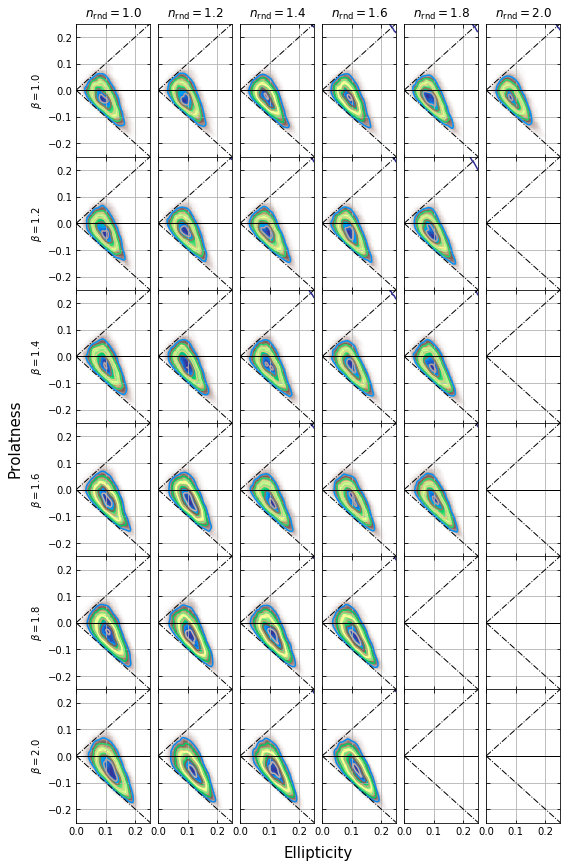

In [9]:
beta_steps  = 6
nrand_steps = 6
ylabelPE = "Prolatness"
xlabelPE = "Ellipticity"

PE_cut_10 = []

fig, ax = plt.subplots(nrows=beta_steps, 
                       ncols=nrand_steps, 
                       sharex=True, 
                       sharey=True,
                       figsize=(8,12))
k = 0
for i in range(beta_steps):
    for j in range(nrand_steps):
        beta  = VoidCats[k][0]
        nrand = VoidCats[k][1] 
        aux = plot_prolatness_vs_ellipticity_R_cut(ax[i][j], VoidCats[k], 10)
        PE_cut_10.append(aux)
        
        if(j==0):
            ax[i][j].set_ylabel(r"$\beta =$" + str(beta))
        if(i==0):
            ax[i][j].set_title(r"$n_{\mathrm{rnd} } =$" + str(nrand))     
        k +=1

fig.text(0.50, 0.02, xlabelPE, va='center', fontsize=15)        
fig.text(0.02, 0.50, ylabelPE, va='center', rotation='vertical', fontsize=15)        

plt.tight_layout(pad=0, rect=(0.06, 0.04, 0.98, 1.0))
#plt.savefig("figures/prolatness_vs_ellipticity_beta_nrand_variations_big_voids.pdf")

In [10]:
PE_cut_10

[[1.0,
  1.0,
  [-0.020298045662837938, 0.09604422560399295, 0.02151749815339568],
  [-0.03090553335716991, -0.030422201935839395, 0.030831616956608594]],
 [1.0,
  1.2,
  [-0.02032417598105174, 0.09443626968042929, 0.020094872695689353],
  [-0.030081303953726345, -0.028544955866745207, 0.030104454963009827]],
 [1.0,
  1.4,
  [-0.019732553532753785, 0.09352779788317662, 0.020008320012207217],
  [-0.03155115635667251, -0.02799492954968887, 0.027481283455578376]],
 [1.0,
  1.6,
  [-0.019206537097273074, 0.09345464907363592, 0.020087201243222427],
  [-0.03169054730622953, -0.02778171780601572, 0.02817602626306878]],
 [1.0,
  1.8,
  [-0.01950209660606303, 0.0927976926143377, 0.020720640930603426],
  [-0.031963115250286216, -0.030380378033947476, 0.027960309289565336]],
 [1.0,
  2.0,
  [-0.01891114013350173, 0.09249564472791208, 0.020941452223162182],
  [-0.030376818897840094, -0.030954835880285407, 0.028261527110130507]],
 [1.2,
  1.0,
  [-0.020269859732741605, 0.09841602913817085, 0.020693

beta=1.0, nrand=1.0. 	ellipticity, prolatness
0.1034 -0.0172 +0.0215	 -0.0568 -0.0251 +0.0401
beta=1.0, nrand=1.2. 	ellipticity, prolatness
0.1101 -0.0279 +0.0263	 -0.0590 -0.0368 +0.0386
beta=1.0, nrand=1.4. 	ellipticity, prolatness
0.1120 -0.0249 +0.0228	 -0.0513 -0.0451 +0.0355
beta=1.0, nrand=1.6. 	ellipticity, prolatness
0.1130 -0.0244 +0.0236	 -0.0592 -0.0356 +0.0387
beta=1.0, nrand=1.8. 	ellipticity, prolatness
0.1188 -0.0245 +0.0190	 -0.0620 -0.0326 +0.0383
beta=1.0, nrand=2.0. 	ellipticity, prolatness
0.1195 -0.0229 +0.0202	 -0.0680 -0.0253 +0.0416
beta=1.2, nrand=1.0. 	ellipticity, prolatness
0.1153 -0.0267 +0.0163	 -0.0616 -0.0338 +0.0449
beta=1.2, nrand=1.2. 	ellipticity, prolatness
0.1115 -0.0187 +0.0245	 -0.0562 -0.0337 +0.0437
beta=1.2, nrand=1.4. 	ellipticity, prolatness
0.1161 -0.0230 +0.0278	 -0.0576 -0.0453 +0.0300
beta=1.2, nrand=1.6. 	ellipticity, prolatness
0.1160 -0.0200 +0.0245	 -0.0580 -0.0343 +0.0385
beta=1.2, nrand=1.8. 	ellipticity, prolatness
0.1187 -0.0205

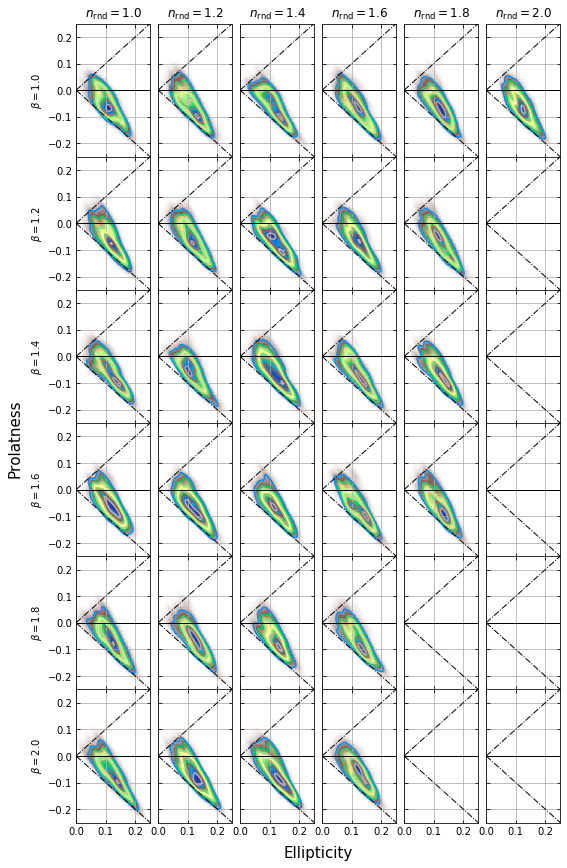

In [11]:
beta_steps  = 6
nrand_steps = 6
ylabelPE = "Prolatness"
xlabelPE = "Ellipticity"

PE_bigvoids = []

fig, ax = plt.subplots(nrows=beta_steps, 
                       ncols=nrand_steps, 
                       sharex=True, 
                       sharey=True,
                       figsize=(8,12))
k = 0
for i in range(beta_steps):
    for j in range(nrand_steps):
        beta  = VoidCats[k][0]
        nrand = VoidCats[k][1] 
        aux = plot_prolatness_vs_ellipticity_R_cut(ax[i][j], VoidCats[k], 30)
        PE_bigvoids.append(aux)
        
        if(j==0):
            ax[i][j].set_ylabel(r"$\beta =$" + str(beta))
        if(i==0):
            ax[i][j].set_title(r"$n_{\mathrm{rnd} } =$" + str(nrand))     
        k +=1

fig.text(0.50, 0.02, xlabelPE, va='center', fontsize=15)        
fig.text(0.02, 0.50, ylabelPE, va='center', rotation='vertical', fontsize=15)        

plt.tight_layout(pad=0, rect=(0.06, 0.04, 0.98, 1.0))
#plt.savefig("figures/prolatness_vs_ellipticity_beta_nrand_variations_big_voids.pdf")

In [12]:
for i in range( len(PE_bigvoids)):
    print(i, PE_bigvoids[i])

0 [1.0, 1.0, [-0.017196182498804363, 0.10338833505196533, 0.02148777028539796], [-0.02509238006469111, -0.05684646409050648, 0.040095625879109836]]
1 [1.0, 1.2, [-0.027942578771547946, 0.11008314120972436, 0.02633228867160016], [-0.036795780034556774, -0.059046022447026, 0.03855141108227791]]
2 [1.0, 1.4, [-0.024909207320762114, 0.11200800599642499, 0.022803516211418046], [-0.045142078131192184, -0.051348703769954596, 0.03551570474881048]]
3 [1.0, 1.6, [-0.02436079976713977, 0.11296321825127997, 0.02355741580884957], [-0.0356013862759611, -0.05915756957821833, 0.03868360237108483]]
4 [1.0, 1.8, [-0.024470972645276895, 0.11876782066602418, 0.018987799108679065], [-0.032587767265582754, -0.062004149331553904, 0.03832583205441063]]
5 [1.0, 2.0, [-0.02289671353195462, 0.11952355168300668, 0.02015983859570905], [-0.025262113213833315, -0.06801047284361542, 0.04159134472453996]]
6 [1.2, 1.0, [-0.026650030235043504, 0.11533602398187055, 0.016345959372133914], [-0.033798103594557594, -0.061603

In [13]:
init = 0
end  = 18

print("e")
print(np.array(PE_bigvoids[init][2]))
print(np.array(PE_bigvoids[end ][2]) - np.array(PE_bigvoids[init][2]))
print(np.array(PE_bigvoids[end ][2]))


print("p")
print(np.array(PE_bigvoids[init][3]))
print(np.array(PE_bigvoids[end ][3]) - np.array(PE_bigvoids[init][3]))
print(np.array(PE_bigvoids[end ][3]))

e
[-0.01719618  0.10338834  0.02148777]
[-0.00474293  0.0080078   0.00224051]
[-0.02193911  0.11139614  0.02372828]
p
[-0.02509238 -0.05684646  0.04009563]
[-1.11769317e-02  1.06425280e-03  8.40346122e-05]
[-0.03626931 -0.05578221  0.04017966]


In [14]:
init = 0
end  = 18

print("e")
print(np.array(PE_cut_10[init][2]))
print(np.array(PE_cut_10[end ][2]) - np.array(PE_cut_10[init][2]))
print(np.array(PE_cut_10[end ][2]))


print("p")
print(np.array(PE_cut_10[init][3]))
print(np.array(PE_cut_10[end ][3]) - np.array(PE_cut_10[init][3]))
print(np.array(PE_cut_10[end ][3]))

e
[-0.02029805  0.09604423  0.0215175 ]
[-0.00082559  0.00987523  0.00079246]
[-0.02112364  0.10591946  0.02230996]
p
[-0.03090553 -0.0304222   0.03083162]
[-0.00267919 -0.00444014  0.00114986]
[-0.03358473 -0.03486234  0.03198148]


In [15]:
init = 0
end  = 22

print("e")
print(np.array(PE_cut_10[init][2]))
print(np.array(PE_cut_10[end ][2]) - np.array(PE_cut_10[init][2]))
print(np.array(PE_cut_10[end ][2]))


print("p")
print(np.array(PE_cut_10[init][3]))
print(np.array(PE_cut_10[end ][3]) - np.array(PE_cut_10[init][3]))
print(np.array(PE_cut_10[end ][3]))

e
[-0.02029805  0.09604423  0.0215175 ]
[-0.0005078   0.00859606  0.0018523 ]
[-0.02080585  0.10464029  0.02336979]
p
[-0.03090553 -0.0304222   0.03083162]
[-0.00368154 -0.00831592  0.00179961]
[-0.03458707 -0.03873812  0.03263123]


In [16]:
e_beta1 = []
p_beta1 = []
for i in [0, 1, 2, 3, 4]:
    e_beta1.append( np.array(PE_cut_10[i][2]))
    p_beta1.append( np.array(PE_cut_10[i][3]))
    
e_beta1 = np.array(e_beta1).T
p_beta1 = np.array(p_beta1).T

e_beta14 = []
p_beta14 = []
for i in [18, 19, 20, 21, 22]:
    e_beta14.append( np.array(PE_cut_10[i][2]))
    p_beta14.append( np.array(PE_cut_10[i][3]))
    
e_beta14 = np.array(e_beta14).T
p_beta14 = np.array(p_beta14).T



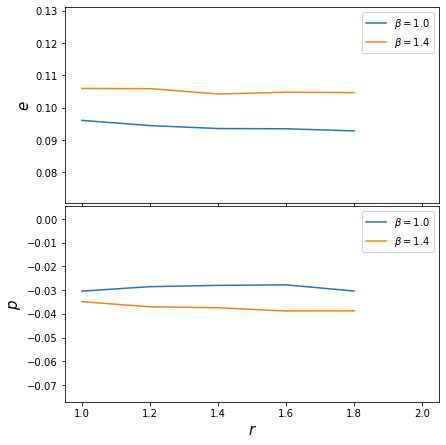

In [17]:
n_rand = np.array([1, 1.2, 1.4, 1.6, 1.8])

fig , ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(6,6))
alpha=0.3

ax[0].plot(n_rand, e_beta1[1], label=r"$\beta=1.0$")
ax[0].fill_between(np.array(nrand), 
                 y1= (e_beta1[1]+e_beta1[2]), 
                 y2= (e_beta1[1]+e_beta1[0]), alpha=alpha)

ax[0].plot(n_rand, e_beta14[1],  label=r"$\beta=1.4$")
ax[0].fill_between(np.array(nrand), 
                 y1= (e_beta14[1]+e_beta14[2]), 
                 y2= (e_beta14[1]+e_beta14[0]), alpha=alpha)
ax[0].set_ylabel(r"$e$", fontsize=15)
ax[0].legend(loc=0)

ax[1].plot(n_rand, p_beta1[1],  label=r"$\beta=1.0$")
ax[1].fill_between(np.array(nrand), 
                 y1= (p_beta1[1]+p_beta1[2]), 
                 y2= (p_beta1[1]+p_beta1[0]), alpha=alpha)

ax[1].plot(n_rand, p_beta14[1],  label=r"$\beta=1.4$")
ax[1].fill_between(np.array(nrand), 
                 y1= (p_beta14[1]+p_beta14[2]), 
                 y2= (p_beta14[1]+p_beta14[0]), alpha=alpha)
ax[1].set_ylabel(r"$p$", fontsize=15)
ax[1].set_xlabel(r"$r$", fontsize=15)

ax[1].legend(loc=0)
plt.tight_layout(pad=0)

plt.savefig("figures/PE_change.pdf")

In [18]:
e_r1 = []
p_r1 = []
for i in [0, 6, 12, 18, 24, 30]:
    e_r1.append( np.array(PE_cut_10[i][2]))
    p_r1.append( np.array(PE_cut_10[i][3]))
    
e_r1 = np.array(e_r1).T
p_r1 = np.array(p_r1).T

e_r14 = []
p_r14 = []
for i in [2, 8, 14, 20, 26, 32]:
    e_r14.append( np.array(PE_cut_10[i][2]))
    p_r14.append( np.array(PE_cut_10[i][3]))
    
e_r14 = np.array(e_r14).T
p_r14 = np.array(p_r14).T

e_r16 = []
p_r16 = []
for i in [3, 9, 15, 21, 27, 33]:
    e_r16.append( np.array(PE_cut_10[i][2]))
    p_r16.append( np.array(PE_cut_10[i][3]))
    
e_r16 = np.array(e_r16).T
p_r16 = np.array(p_r16).T


In [19]:
print(e_r1.shape)
print(e_r14.shape)
print(e_r16.shape)

(3, 6)
(3, 6)
(3, 6)


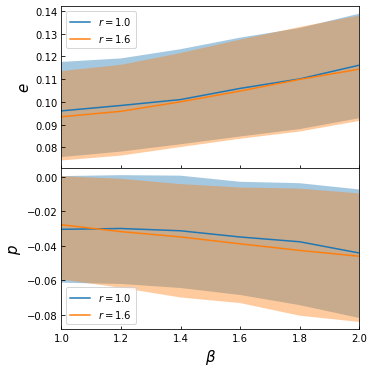

In [20]:
beta   = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

fig , ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(5,5))
alpha=0.4

ax[0].plot(beta, e_r1[1], label=r"$r=1.0$")
ax[0].fill_between(x=beta, 
                 y1= (e_r1[1]+e_r1[2]), 
                 y2= (e_r1[1]+e_r1[0]), alpha=alpha)

ax[0].plot(beta, e_r16[1],  label=r"$r=1.6$")
ax[0].fill_between(x=beta, 
                 y1= (e_r16[1]+e_r16[2]), 
                 y2= (e_r16[1]+e_r16[0]), alpha=alpha)
ax[0].set_ylabel(r"$e$", fontsize=15)
ax[0].legend(loc=2)


ax[1].plot(beta, p_r1[1], label=r"$r=1.0$")
ax[1].fill_between(x=beta, 
                 y1= (p_r1[1]+p_r1[2]), 
                 y2= (p_r1[1]+p_r1[0]), alpha=alpha)

ax[1].plot(beta, p_r16[1],  label=r"$r=1.6$")
ax[1].fill_between(x=beta, 
                 y1= (p_r16[1]+p_r16[2]), 
                 y2= (p_r16[1]+p_r16[0]), alpha=alpha)
ax[1].set_ylabel(r"$p$", fontsize=15)
ax[1].set_xlabel(r"$\beta$", fontsize=15)
ax[1].legend(loc=3)


for i in range(2):
    ax[i].tick_params(direction="in")
    ax[i].set_xlim(1,2)


plt.tight_layout(pad=0)

plt.savefig("figures/PE_change.pdf")

In [21]:
def truncate_colormap(cmapIn='gist_heat_r', minval=0.0, maxval=1.0, n=100):
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    arr = np.linspace(0, 50, 100).reshape((10, 10))
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(arr, interpolation='nearest', cmap=cmapIn)
    ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
    plt.show()

    return new_cmap


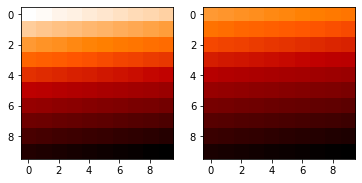

In [22]:
cmap_mod = truncate_colormap(minval=0.2, maxval=1.0)

In [23]:
def scatter_prolatness_vs_ellipticity_R_cut(ax, Dataset, R_cut):
    
    unity = np.array([0,0.25])

    beta    = Dataset[0]
    nrand   = Dataset[1]
    VoidCat = Dataset[-1]

    xmin, xmax, ymin, ymax =  0, 0.25, -0.25, 0.25
    
    if (VoidCat.shape != (1,1)):
        #print(VoidCat[:5,5])
        VoidCat = VoidCat[VoidCat[:,5].argsort()]
        #print(VoidCat[:5,5])
        
        R = VoidCat[:,5]
        
        index = np.where(R > R_cut)[0]
        
        a = VoidCat[index,6]
        b = VoidCat[index,7]
        c = VoidCat[index,8]

        e = ellipticity(a,b,c)
        p = prolatness(a,b,c)

        
        e_p = np.percentile(e, [25, 50, 75])
        p_p = np.percentile(p, [25, 50, 75])
        
        e_m     = e_p[1]
        e_minus = e_p[0] - e_p[1]
        e_plus  = e_p[2] - e_p[1]
        p_m     = p_p[1]
        p_minus = p_p[0] - p_p[1]
        p_plus  = p_p[2] - p_p[1]
        
        R_min = R[index].min()
        R_max = R[index].max()
        Rscale = R_max - R_min
        RColour = 0.7 + 0.3*(R[index] - R_min) / Rscale
        
        print("beta={:2.1f}, nrand={:2.1f}. \tellipticity, prolatness".format(beta, nrand))
        print("{:1.4f} {:1.4f} {:1.4f}\t {:1.4f} {:1.4f} {:1.4f}".format(e_m, e_minus, e_plus, p_m, p_minus, p_plus))

        """
        ### Kernel Density begins here.
        X, Y, Z = density_estimation(e, p, xmin, xmax, ymin, ymax)
        ax.imshow(np.rot90(Z), 
                     cmap=plt.cm.terrain_r, 
                     extent=[xmin, xmax, ymin, ymax], 
                     aspect='auto')   #aspect='auto','1'
        #plt.colorbar()
        # Add contour lines
        ax.contour(X, Y, Z, cmap="terrain")       
        ### Kernel Density ends here.
        """
        #ax.scatter(e,p, s=1, alpha=1.0, c=RColour, cmap="copper_r")
        ax.scatter(e,p, s=4, alpha=1.0, c=RColour, cmap=cmap_mod)
        
    ax.plot(unity,  unity, linestyle="-.", color="k", lw=1)
    ax.plot(unity, -unity, linestyle="-.", color="k", lw=1)
    ax.axhline(0, color="k", lw=1)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.tick_params(axis="x",   top=True, direction="in")
    ax.tick_params(axis="y", right=True, direction="in")
    
    ax.set_xticks([0,0.1,0.2])
    ax.set_xticklabels(["0.0", "0.1", "0.2"])
    ax.grid(True, which="both", axis="both")

    

beta=1.0, nrand=1.0. 	ellipticity, prolatness
0.1034 -0.0172 0.0215	 -0.0568 -0.0251 0.0401
beta=1.0, nrand=1.2. 	ellipticity, prolatness
0.1101 -0.0279 0.0263	 -0.0590 -0.0368 0.0386
beta=1.0, nrand=1.4. 	ellipticity, prolatness
0.1120 -0.0249 0.0228	 -0.0513 -0.0451 0.0355
beta=1.0, nrand=1.6. 	ellipticity, prolatness
0.1130 -0.0244 0.0236	 -0.0592 -0.0356 0.0387
beta=1.0, nrand=1.8. 	ellipticity, prolatness
0.1188 -0.0245 0.0190	 -0.0620 -0.0326 0.0383
beta=1.0, nrand=2.0. 	ellipticity, prolatness
0.1195 -0.0229 0.0202	 -0.0680 -0.0253 0.0416
beta=1.2, nrand=1.0. 	ellipticity, prolatness
0.1153 -0.0267 0.0163	 -0.0616 -0.0338 0.0449
beta=1.2, nrand=1.2. 	ellipticity, prolatness
0.1115 -0.0187 0.0245	 -0.0562 -0.0337 0.0437
beta=1.2, nrand=1.4. 	ellipticity, prolatness
0.1161 -0.0230 0.0278	 -0.0576 -0.0453 0.0300
beta=1.2, nrand=1.6. 	ellipticity, prolatness
0.1160 -0.0200 0.0245	 -0.0580 -0.0343 0.0385
beta=1.2, nrand=1.8. 	ellipticity, prolatness
0.1187 -0.0205 0.0249	 -0.0605 -0.

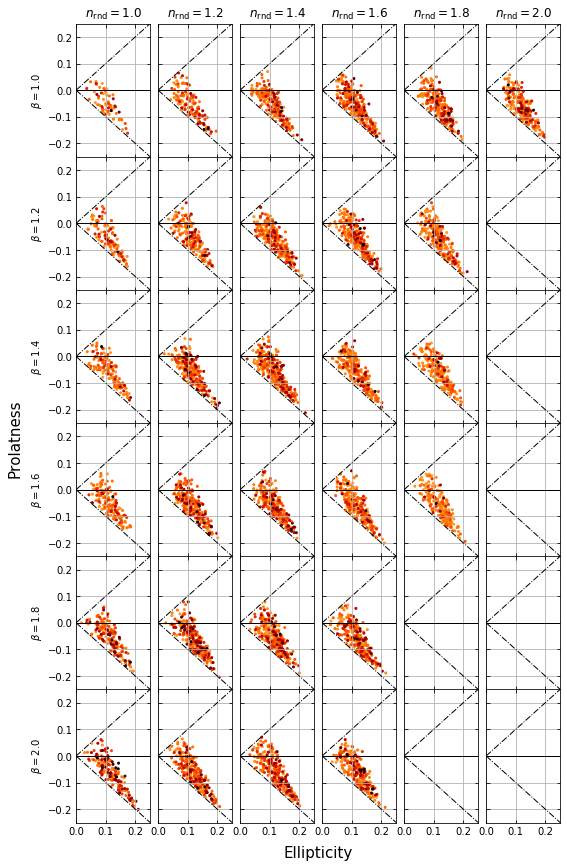

In [24]:
beta_steps  = 6
nrand_steps = 6
ylabelPE = "Prolatness"
xlabelPE = "Ellipticity"

fig, ax = plt.subplots(nrows=beta_steps, 
                       ncols=nrand_steps, 
                       sharex=True, 
                       sharey=True,
                       figsize=(8,12))
k = 0
for i in range(beta_steps):
    for j in range(nrand_steps):
        beta  = VoidCats[k][0]
        nrand = VoidCats[k][1] 
        scatter_prolatness_vs_ellipticity_R_cut(ax[i][j], VoidCats[k], 30)

        if(j==0):
            ax[i][j].set_ylabel(r"$\beta =$" + str(beta))
        if(i==0):
            ax[i][j].set_title(r"$n_{\mathrm{rnd} } =$" + str(nrand))     
        k +=1

fig.text(0.50, 0.02, xlabelPE, va='center', fontsize=15)        
fig.text(0.02, 0.50, ylabelPE, va='center', rotation='vertical', fontsize=15)        

plt.tight_layout(pad=0, rect=(0.06, 0.04, 0.98, 1.0))
plt.savefig("figures/prolatness_vs_ellipticity_beta_nrand_variations_big_voids_scatter.pdf")

# Fraction of Volume in Voids vs Box Volume 

In [25]:
# Sort by beta, then by nrand.
VoidCats.sort(key = lambda x: x[0])
VoidCats.sort(key = lambda x: x[1])

linestyles = ['solid', 'dashed', 'dashdot', 'dotted', 'solid', 'dashed', 'dashdot', 'dotted']
linecolour = ['k', 'k', 'k', 'k', 'gray', 'gray', 'gray', 'gray']

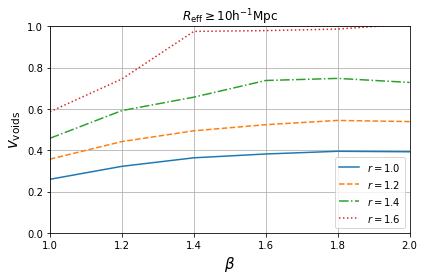

In [26]:
beta_steps  = 6
nrand_steps = 4

R_cut = 10 # Mpc/h

k = 0
for i in range(nrand_steps):
    beta_list = []
    vol_frac  = []
    vol_trim_frac = []
    
    for j in range(beta_steps):
        beta    = VoidCats[k][0]
        nrand   = VoidCats[k][1] 
        Dataset = VoidCats[k][2]
        k+=1
        if (Dataset.shape != (1,1)):
            R = Dataset[:,5]
            V = (4.0/3.0) * np.pi * R**3
            index = np.where(R> R_cut)
            Vtrim = (4.0/3.0) * np.pi *R[index]**3
            Vt = np.sum(V)     
            Vttrim = np.sum(Vtrim)
            
            beta_list.append(beta)
            vol_frac.append(Vt/ Volume)
            vol_trim_frac.append(Vttrim/ Volume)
    if( i!= 5):
        plt.plot(beta_list, vol_trim_frac, ls=linestyles[i],
                 label=r"$r=$" + str(nrand))
    else:
        plt.scatter(beta_list, vol_trim_frac, marker="+",
                 label=r"$r=$" + str(nrand))
plt.xlim(0.95,2.05)
#plt.ylim(0.035,2.0)
plt.xlim(1.0,2.0)
plt.ylim(0.0,1.0)
plt.title(r"$R_\mathrm{eff} \geq$" + str(R_cut) + r"$\mathrm{h^{-1}Mpc}$")
plt.ylabel(r"$v_\mathrm{voids}$", fontsize=15)        
plt.xlabel(r"$\beta$", fontsize=15)

plt.grid(True, which='major', axis="x")
plt.grid(True, which='both', axis="y")
plt.legend(loc=4)

plt.tight_layout()
plt.savefig("./figures/volume_fraction_occupied_by_voids_geq_10Mpch.pdf")


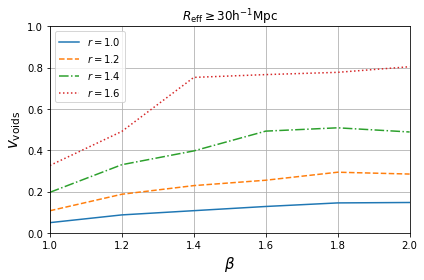

In [27]:
beta_steps  = 6
nrand_steps = 4

R_cut = 30 # Mpc/h

k = 0
for i in range(nrand_steps):
    beta_list = []
    vol_frac  = []
    vol_trim_frac = []
    
    for j in range(beta_steps):
        beta    = VoidCats[k][0]
        nrand   = VoidCats[k][1] 
        Dataset = VoidCats[k][2]
        k+=1
        if (Dataset.shape != (1,1)):
            R = Dataset[:,5]
            V = (4.0/3.0) * np.pi * R**3
            index = np.where(R> R_cut)
            Vtrim = (4.0/3.0) * np.pi *R[index]**3
            Vt = np.sum(V)     
            Vttrim = np.sum(Vtrim)
            
            beta_list.append(beta)
            vol_frac.append(Vt/ Volume)
            vol_trim_frac.append(Vttrim/ Volume)
    if( i!= 5):
        plt.plot(beta_list, vol_trim_frac, ls=linestyles[i],
                 label=r"$r=$" + str(nrand))
    else:
        plt.scatter(beta_list, vol_trim_frac, marker="+",
                 label=r"$r=$" + str(nrand))
plt.xlim(0.95,2.05)
#plt.ylim(0.035,2.0)
plt.xlim(1.0,2.0)
plt.ylim(0.0,1.0)
plt.title(r"$R_\mathrm{eff} \geq$" + str(R_cut) + r"$\mathrm{h^{-1}Mpc}$")
plt.ylabel(r"$v_\mathrm{voids}$", fontsize=15)        
plt.xlabel(r"$\beta$", fontsize=15)

plt.grid(True, which='major', axis="x")
plt.grid(True, which='both', axis="y")
plt.legend(loc=2)

plt.tight_layout()
plt.savefig("./figures/volume_fraction_occupied_by_voids_geq_30Mpch.pdf")


In [28]:
!head -n 2 volume_and_excentricity/60.vae

# Void_ID, X_c, Y_c, Z_c, N_particles, R=(abc)^(-1/3), a, b, c, vector_a, vector_b, vector_c 



In [29]:
!wc -l observed_catalogs/v300.dat

271452 observed_catalogs/v300.dat


Halo density in the 720 Mpc/h box 0.0007272698045267489

Particle density in the void
beta nrand, part_density, part_density/halo_density
1.0 1.0 0.000643 0.884
1.2 1.0 0.000623 0.857
1.4 1.0 0.000623 0.857
1.6 1.0 0.000603 0.828
1.8 1.0 0.000593 0.815
2.0 1.0 0.000575 0.79
1.0 1.2 0.000615 0.846
1.2 1.2 0.000597 0.82
1.4 1.2 0.000573 0.787
1.6 1.2 0.000572 0.786
1.8 1.2 0.000547 0.752
2.0 1.2 0.000542 0.746
1.0 1.4 0.000585 0.804
1.2 1.4 0.000558 0.768
1.4 1.4 0.000542 0.746
1.6 1.4 0.000518 0.713
1.8 1.4 0.000517 0.71
2.0 1.4 0.000509 0.699
1.0 1.6 0.000559 0.768
1.2 1.6 0.000531 0.73
1.4 1.6 0.000507 0.698
1.6 1.6 0.000492 0.676
1.8 1.6 0.000483 0.664
2.0 1.6 0.00048 0.66


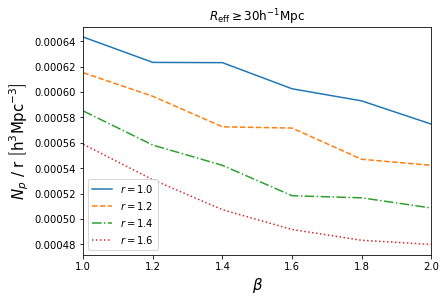

In [30]:
HalosInCatalog = 271452
HaloDensity = 271452.  / (720.**3)
print("Halo density in the 720 Mpc/h box" , HalosInCatalog * 720.0**(-3))

R_cut = 30 # Mpc/h

beta_steps  = 6
nrand_steps = 4

print("\nParticle density in the void")
print("beta nrand, part_density, part_density/halo_density")
k = 0
for i in range(nrand_steps):
    
    beta_list = []
    ratio_list = []
    
    for j in range(beta_steps):
        beta    = VoidCats[k][0]
        nrand   = VoidCats[k][1] 
        Dataset = VoidCats[k][2]
        k+=1
        
        
        if (Dataset.shape != (1,1)):
            R     = Dataset[:,5]                    
            index = np.where(R >= R_cut)
            V     = (4.0/3.0) * np.pi * R[index]**3
            Np    = Dataset[index,4] 
            
            ratio = Np / (nrand * V)
            
            print(beta, nrand, np.round(ratio.mean(), decimals=6), 
                  np.round(ratio.mean()/HaloDensity, decimals=3) ) 

            beta_list.append(beta)
            ratio_list.append(ratio.mean())
    
    if( i!= 5):
        plt.plot(beta_list, ratio_list, ls=linestyles[i],
                 label=r"$r=$" + str(nrand))
    else:
        plt.scatter(beta_list, ratio_list, marker="+",
                 label=r"$r=$" + str(nrand))

#plt.axhline(y=HaloDensity, label="Halo Density")
        
ylabelUnits = r"$ \left[ \mathrm{h^{3} Mpc^{-3}} \right]$"

plt.xlim(1,2)
plt.ylabel(r"$N_p$ / r " + ylabelUnits, fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)
plt.title(r"$R_\mathrm{eff} \geq 30 {\rm h^{-1}Mpc}$")
plt.legend(loc=3)
plt.tight_layout(pad=0)

### Checking  for $\beta=1.0$ and $n_{rnd}=1.0$

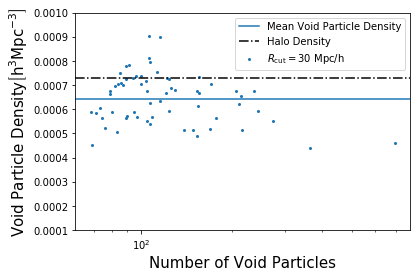

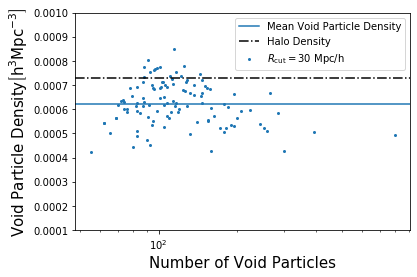

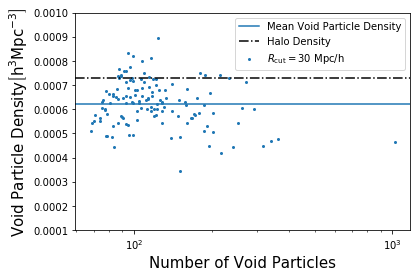

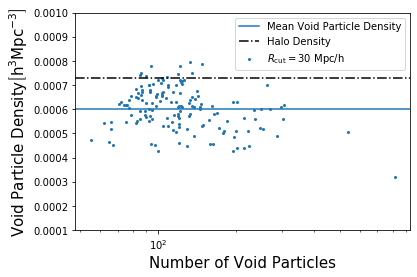

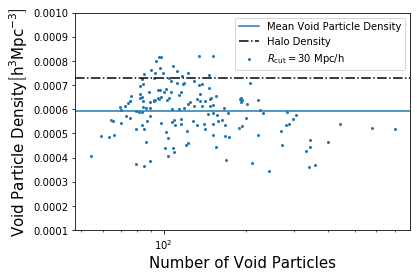

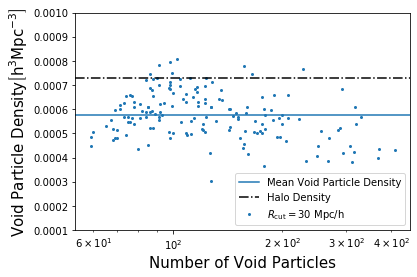

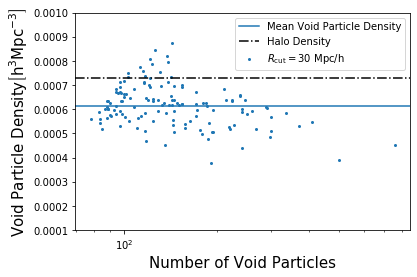

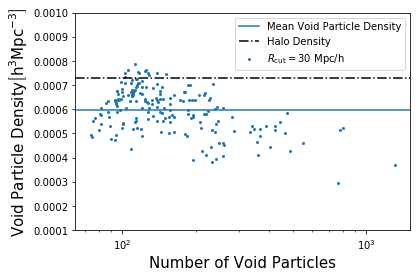

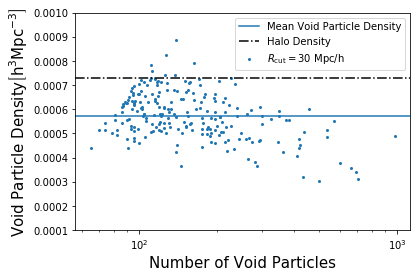

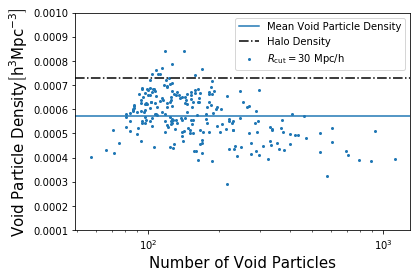

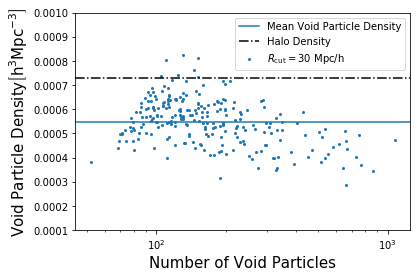

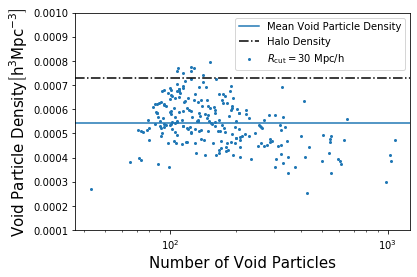

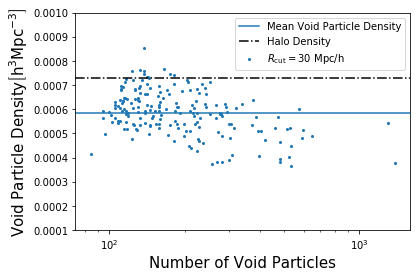

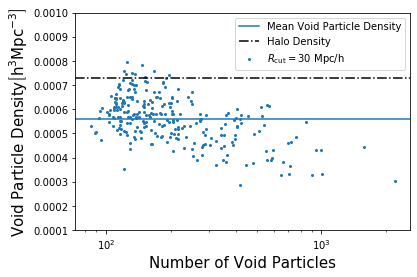

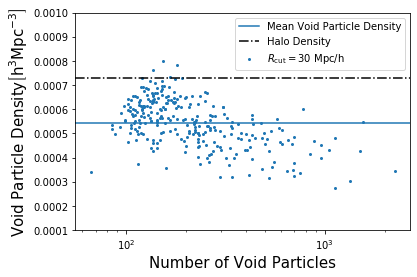

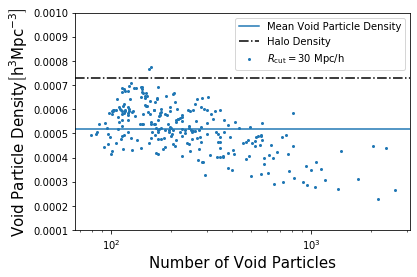

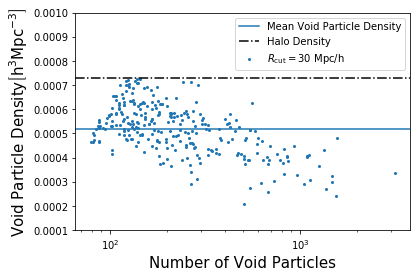

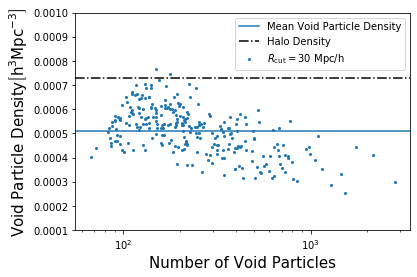

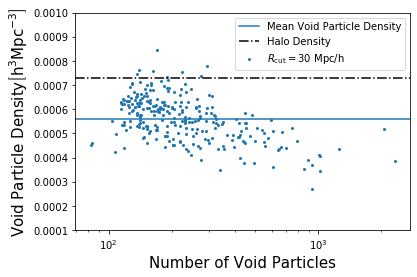

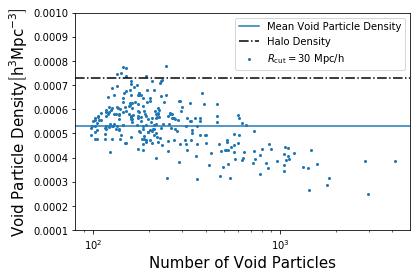

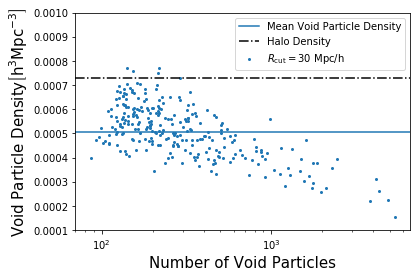

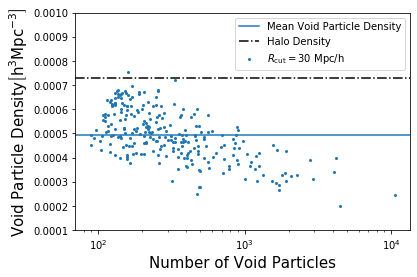

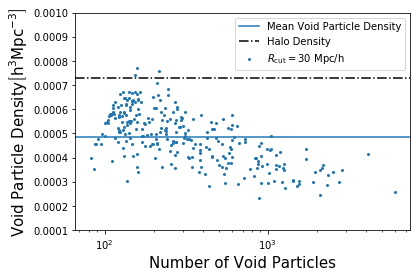

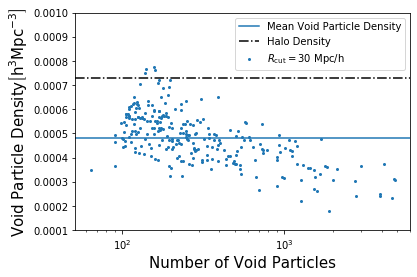

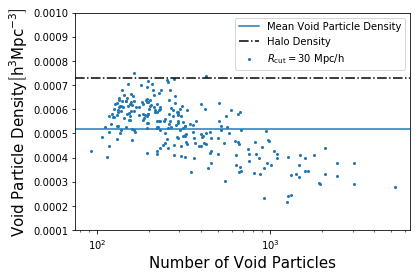

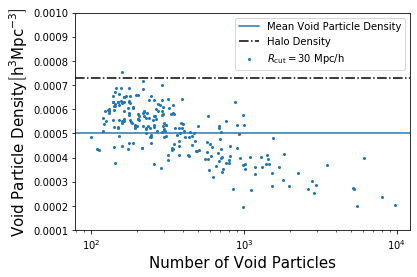

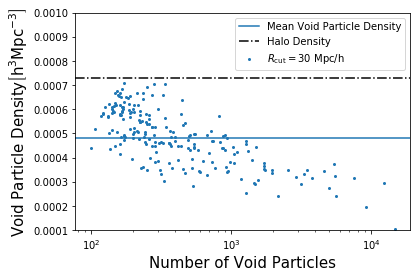

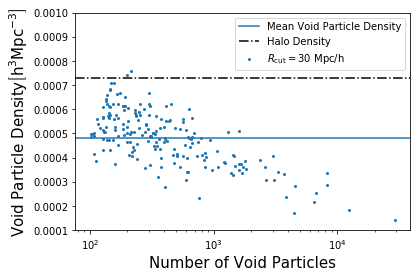

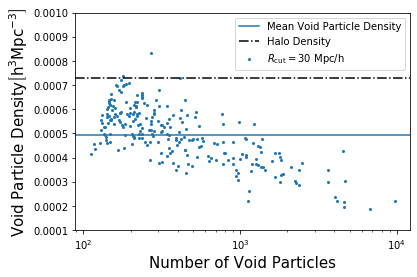

In [31]:
for k in range(ncats):

    beta    = VoidCats[k][0]
    nrand   = VoidCats[k][1] 
    Dataset = VoidCats[k][2]

    if (Dataset.shape != (1,1)):
        R = Dataset[:,5]
        Np = Dataset[:,4]
        V = (4/3.) * np.pi * R**3
        R_cut = 30

        index = np.where(R> R_cut)

        void_particle_density = Np[index] / (V[index] * nrand)

        plt.figure()
        plt.scatter(Np[index], void_particle_density, s=4, label=r"$R_\mathrm{cut}=$" + str(R_cut) + " Mpc/h")
        plt.axhline(y = void_particle_density.mean(), label = "Mean Void Particle Density")
        plt.axhline(y= 271452.0 * 720**(-3), c="k", ls="dashdot", label = "Halo Density")

        #plt.yscale("log")
        plt.xscale("log")
        plt.ylim(0.0001, 0.001)
        plt.xlabel("Number of Void Particles", fontsize=15)
        plt.ylabel("Void Particle Density" + ylabelUnits, fontsize=15)
        plt.legend(loc=0)
        plt.show()
        plt.close()

10
[0.00045993]


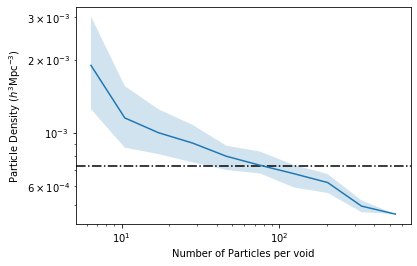

In [32]:
Nbins = 10
k = 0
beta    = VoidCats[k][0]
nrand   = VoidCats[k][1] 
Dataset = VoidCats[k][2]
if (Dataset.shape != (1,1)):
    R = Dataset[:,5]
    Np = Dataset[:,4]
    V = (4/3.) * np.pi * R**3
    logNp = np.log10(Np)
    hist, bins= np.histogram( logNp, bins=Nbins )
    bins_c = ( bins[1:] + bins[:-1] )/2.
    
    vdp_aux = []
    for l in range(Nbins):
        index2  = np.where((logNp >= bins[l]) & (logNp <= bins[l+1]))[0]
        vdp_aux.append( Np[index2] / (V[index2] * nrand))

    q1 = []
    q2 = []
    q3 = []
    
    print(len(vdp_aux))

    print(vdp_aux[-1])

    for l in range(Nbins):
        q1.append(np.percentile(vdp_aux[l], 25))
        q2.append(np.percentile(vdp_aux[l], 50))
        q3.append(np.percentile(vdp_aux[l], 75))
        
    plt.axhline(y= 271452.0 * 720**(-3), c="k", ls="dashdot", label = "Halo Density")
    plt.plot(10**bins_c, q2)    
    plt.fill_between(10**bins_c, q1, q3, alpha=0.2)
    
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Number of Particles per void")
    plt.ylabel(r"Particle Density ($h^3 \mathrm{Mpc}^{-3}$)")

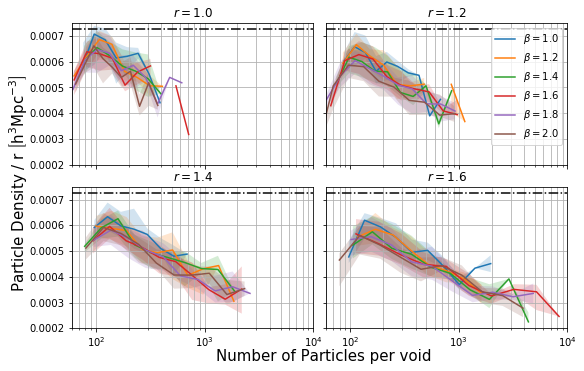

In [33]:
# Sort by nrand, then by beta
#VoidCats.sort(key = lambda x: x[0])
#VoidCats.sort(key = lambda x: x[1])

Nbins = 10
R_cut = 30

beta_steps  = 6
nrand_steps = 4

ncols = 2
nrows = 2

fig, ax = plt.subplots(nrows= nrows, 
                       ncols= ncols, 
                       sharex=True, 
                       sharey=True,
                       figsize=(8,5))

ylabelUnits = r"$ \left[ \mathrm{h^{3} Mpc^{-3}} \right]$"

k = 0
for i in range(nrows):
    for j in range(ncols):
        
        #ax[i][j].scatter([100,1000], [0.0007, 0.0002])
        ax[i][j].grid(True, which="both", axis="both")
       
        for m in range(beta_steps):
            beta    = VoidCats[k][0]
            nrand   = VoidCats[k][1] 
            Dataset = VoidCats[k][2]

            k+=1
            if (Dataset.shape != (1,1)):
                R = Dataset[:,5]

                index1 = np.where(R >= R_cut)[0]            
                Np = Dataset[index1,4]
                V = (4/3.) * np.pi * R[index1]**3

                logNp = np.log10(Np)

                hist, bins= np.histogram( logNp, bins=Nbins )
                bins_c = ( bins[1:] + bins[:-1] )/2.

                vdp_aux = []
                for l in range(Nbins):
                    index2  = np.where((logNp >= bins[l]) & (logNp <= bins[l+1]))[0]
                    vdp_aux.append( Np[index2] / (V[index2] * nrand))

                q1 = []
                q2 = []
                q3 = []

                for l in range(Nbins):
                    if(len(vdp_aux[l])==0): # Percentile throws error when  the array is empty
                        q1.append(np.nan)
                        q2.append(np.nan)
                        q3.append(np.nan)
                    else:
                        q1.append(np.percentile(vdp_aux[l], 25))
                        q2.append(np.percentile(vdp_aux[l], 50))
                        q3.append(np.percentile(vdp_aux[l], 75))

                ax[i][j].plot(10**bins_c, q2, label=r"$\beta=$"+str(beta))    
                ax[i][j].fill_between(10**bins_c, q1, q3, alpha=0.2)
        
                
        ax[i][j].set_title(r"$r=$"+str(nrand))
        
        if(i==0)&(j==1):
            ax[i][j].legend(loc=1)
        
        ax[i][j].set_xlim(60, 10000)
        ax[i][j].set_ylim(2e-4, 7.5e-4)
        ax[i][j].set_xscale("log")
        ax[i][j].axhline(y= 271452.0 * 720**(-3), c="k", ls="dashdot", label = "Halo Density")


xlabel = "Number of Particles per void"
ylabel = "Particle Density / r " + ylabelUnits    

fig.text(0.55, 0.02, xlabel, va='center', ha='center', fontsize=15)        
fig.text(0.02, 0.50, ylabel, va='center', ha='center', rotation='vertical', fontsize=15)        

plt.tight_layout(pad=0, rect=(0.04, 0.04, 0.99, 0.99))
plt.savefig("figures/particle_density_in_big_voids.pdf")